
<table>
<tr>
<td width=15%><img src="./img/UGA.png"></img></td>
<td><center><h1>Refresher Course on Matrix Analysis and Optimization</h1></center></td>
<td width=15%><a href="http://www.iutzeler.org" style="font-size: 16px; font-weight: bold">Franck Iutzeler</a> <a href="https://ljk.imag.fr/membres/Jerome.Malick/" style="font-size: 16px; font-weight: bold">Jerome Malick</a><br/> Fall. 2018 </td>
</tr>
</table>


<br/><br/><div id="top"></div>

<center><a style="font-size: 40pt; font-weight: bold">Chap. 1 - Introduction to Python </a></center>

<br/>

# ``3. Examples in Data Science``

---

## <a id="supCla"> b) Binary Classification</a>  


<p style="text-align: right; font-size: 10px;"><a href="#top">Go to top</a></p>



[[  6.37734541 -10.61510727]
 [  6.50072722  -3.82403586]
 [  4.29225906  -8.99220442]
 [  7.39169472  -3.1266933 ]
 [  7.64306311 -10.02356892]] [1 0 1 0 1]


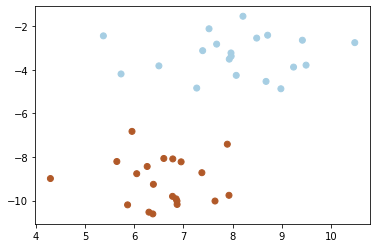

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
%matplotlib inline

# we create 40 separable points in R^2 around 2 centers (random_state=6 is a seed so that the set is separable)
X, y = make_blobs(n_samples=40, n_features=2, centers=2 , random_state=6)

print(X[:5,:],y[:5]) # print the first 5 points and labels

plt.scatter(X[:, 0], X[:, 1], c=y,  cmap=plt.cm.Paired)

Support Vector Machines (SVM) are based on learning a vector $w$ and an intercept $b$ such that the hyperplane $w^T x - b = 0$ separates the data i.e.  $a$ belongs to one class if  $w^T a - b > 0$ and the other elsewhere. 


They were later extended to *Kernel methods* that is  $\kappa(w, a) - b = 0$ is now the separating *curve* where $\kappa$ is the *kernel*, typically:
* linear: $\kappa(x,y)= x^T y$ (original SVM) 
* polynomial: $\kappa(x,y)= (x^T y)^d$ 
* Gaussian radial basis function (rfb):   $\kappa(x,y)= \exp( - \gamma \| x - y \|^2 )$

In [2]:
from sklearn.svm import SVC # Support vector classifier i.e. Classifier by SVM

modelSVMLinear = SVC(kernel="linear")
modelSVMLinear.fit(X,y)

SVC(kernel='linear')

The following illustration can be found in the [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) by Jake VanderPlas.

In [3]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    

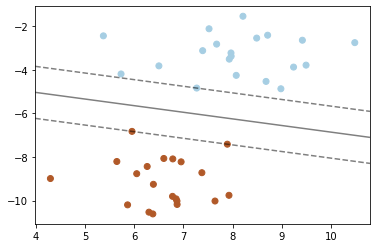

In [4]:
plt.scatter(X[:, 0], X[:, 1], c=y ,  cmap=plt.cm.Paired)
plot_svc_decision_function(modelSVMLinear)

We see clearly that the linear SVM seeks at maximizing the *margin* between the hyperplane and the two well defined classes from the data.

### Non-separable data

In real cases, the data is usually not linearly separable as before.

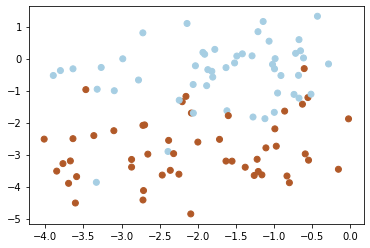

In [5]:
# we create points in R^2 around 2 centers (random_state=48443 is a seed so that the set is *not* separable)
X, y = make_blobs(n_samples=100, n_features=2, centers=2 , random_state=48443)

plt.scatter(X[:, 0], X[:, 1], c=y,  cmap=plt.cm.Paired)

Let us use the *same* linear SVM classifier. Obviously, there are *misclassified points*, the model is thus learnt not by maximizing the margin (which does not exist anymore) but by minimizing a penalty over misclassified data. This penalty takes the form of an allowance margin controlled by a parameter $C$. The smaller $C$ the more inclusive the margin. Finding a good value for $C$ is up to the data scientist.

In [6]:
try:
    from sklearn.model_selection import train_test_split    # sklearn > ...
except:
    from sklearn.cross_validation import train_test_split   # sklearn < ...
    
XTrain, XTest, yTrain, yTest = train_test_split(X,y,test_size = 0.5) # split data in two

model1 = SVC(kernel="linear",C=0.01)
model1.fit(XTrain,yTrain)

model2 = SVC(kernel="linear",C=100)
model2.fit(XTrain,yTrain)

SVC(C=100, kernel='linear')

Text(0.5, 1.0, 'C = 0.01')

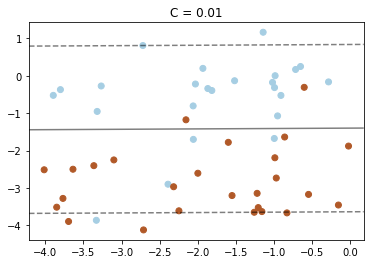

In [7]:
plt.scatter(XTrain[:, 0], XTrain[:, 1], c=yTrain ,  cmap=plt.cm.Paired)
plot_svc_decision_function(model1)
plt.title("C = 0.01")

Text(0.5, 1.0, 'C = 100')

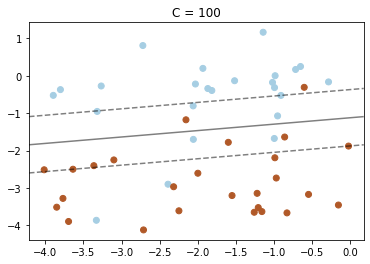

In [8]:
plt.scatter(XTrain[:, 0], XTrain[:, 1], c=yTrain ,  cmap=plt.cm.Paired)
plot_svc_decision_function(model2)
plt.title("C = 100")

To find out which value of $C$ to use or globally the performance of the classifier, one can use Scikit Learn's [classification metrics](http://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics), for instance the confusion matrix.

In [9]:
from sklearn.metrics import confusion_matrix


yFit1 = model1.predict(XTest)
yFit2 = model2.predict(XTest)


mat1 = confusion_matrix(yTest, yFit1)
mat2 = confusion_matrix(yTest, yFit2)

print('Model with C = 0.01')
print(mat1)
print("Model with C = 100")
print(mat2)

Model with C = 0.01
[[23  3]
 [ 3 21]]
Model with C = 100
[[23  3]
 [ 3 21]]


It can also be plotted in a fancier way with seaborn.

Text(0.5, 15.0, 'predicted label')

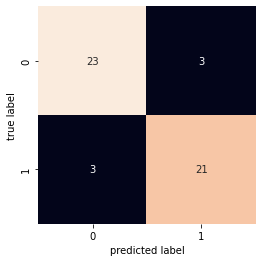

In [11]:
import seaborn as sns

sns.heatmap(mat1, square=True, annot=True ,cbar=False)
plt.ylabel('true label')
plt.xlabel('predicted label')

<div class="exo"> <b>Exercise 1-3.2:</b> 
a very popular binary classification exercise is the <a href="https://www.kaggle.com/c/titanic">survival prediction from Titanic shipwreck on Kaggle</a>. <br/><br/>

<i> The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.<br/>

    One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.<br/>

    In this challenge, we ask you to complete the analysis of what sorts of people were likely to survive. In particular, we ask you to apply the tools of machine learning to predict which passengers survived the tragedy.<br/><br/><br/></i>
    
    
The data - taken from <a href="https://www.kaggle.com/c/titanic">Kaggle</a> - is located in <tt>data/titanic/train.csv</tt> and has the following form:

<table>
<tbody>
<tr><th><b>Feature</b></th><th><b>Definition</b></th><th><b>Comment</b></th></tr>
<tr>
<td>PassengerId</td>
<td>ID</td>
<td>numeric</td>
</tr>
<tr>
<td>Survival</td>
<td>Survival of the passenger</td>
<td>0 = No, 1 = Yes <b>target to predict</b></td>
</tr>
<tr>
<td>Pclass</td>
<td>Ticket class</td>
<td>1 = 1st, 2 = 2nd, 3 = 3rd</td>
</tr>
<tr>
<td>Name</td>
<td>Full name w/ Mr. Mrs. etc.</td>
<td>string</td>
</tr>
<tr>
<td>Sex</td>
<td>Sex</td>
<td><tt>male</tt> or <tt>female</tt></td>
</tr>
<tr>
<td>Age</td>
<td>Age in years</td>
<td>numeric</td>
</tr>
<tr>
<td>SibSp</td>
<td># of siblings / spouses aboard the Titanic</td>
<td>numeric</td>
</tr>
<tr>
<td>Parch</td>
<td># of parents / children aboard the Titanic</td>
<td></td>
</tr>
<tr>
<td>Ticket</td>
<td>Ticket number</td>
<td>quite messy</td>
</tr>
<tr>
<td>Fare</td>
<td>Passenger fare</td>
<td></td>
</tr>
<tr>
<td>cabin</td>
<td>Cabin number</td>
<td>letter + number (e.g. C85), often missing</td>
</tr>
<tr>
<td>Embarked</td>
<td>Port of Embarkation</td>
<td>C = Cherbourg, Q = Queenstown, S = Southampton</td>
</tr>
</tbody>
</table>

<ul>
<li> Load the dataset and preprocess the features. (you can remove features that seem uninteresting to you).
<li> Perform binary classification to predict the survival of a passenger depending on its information and validate you approach.
<li> Perform some feature engineering to improve the performance of you classifier (see e.g. <a href="https://triangleinequality.wordpress.com/2013/09/08/basic-feature-engineering-with-the-titanic-data/">here</a>)
</ul>
</div>